#import libraries

In [2]:
import torch
import cv2
import numpy as np
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import os
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from glob import glob
import pandas as pd
from torchvision.io import read_image
from torch.utils.data import DataLoader
from torchvision.models import *
from torchsummary import summary
import torch.nn.functional as F
import torch.nn as nn
from torch import optim
from torchvision.models.feature_extraction import create_feature_extractor, get_graph_node_names
from xgboost import XGBClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, recall_score, precision_score, \
    f1_score, confusion_matrix

#load data

download data

In [3]:
!gdown 176xONGNc1TMTpAk_vPayOrRJrUPpSsip
!unzip -qq /content/German-Traffic-Signs-Dataset-GTSRB-master.zip

Downloading...
From (original): https://drive.google.com/uc?id=176xONGNc1TMTpAk_vPayOrRJrUPpSsip
From (redirected): https://drive.google.com/uc?id=176xONGNc1TMTpAk_vPayOrRJrUPpSsip&confirm=t&uuid=562b16a2-ab75-41d1-9594-22391665fe40
To: /content/German-Traffic-Signs-Dataset-GTSRB-master.zip
100% 324M/324M [00:07<00:00, 40.8MB/s]


In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

load train data

In [5]:
training_data = ImageFolder(root="German-Traffic-Signs-Dataset-GTSRB-master/Train",
                            transform=transforms.Compose([
                                transforms.Resize((224, 224)),
                                transforms.ToTensor()]))

train_dataloader = DataLoader(training_data, batch_size=500, shuffle=True)

load test data

In [6]:
import os
import pandas as pd
from torchvision.io import read_image
from torch.utils.data import Dataset
from torch.utils.data import DataLoader


class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 7])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 6]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label


test_data = CustomImageDataset(
    annotations_file="German-Traffic-Signs-Dataset-GTSRB-master/Test.csv",
    img_dir="/content/German-Traffic-Signs-Dataset-GTSRB-master",
    transform=transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224, 224)),
        transforms.ToTensor()])
    )

test_dataloader = DataLoader(test_data, batch_size=500, shuffle=True)

calculate mean and std

In [7]:
def get_mean_std(loader):
    num_pixels = 0
    mean = 0.0
    std = 0.0
    for images, _ in loader:
        batch_size, num_channels, height, width = images.shape
        num_pixels += batch_size * height * width
        mean += images.mean(axis=(0, 2, 3)).sum()
        std += images.std(axis=(0, 2, 3)).sum()

    mean /= num_pixels
    std /= num_pixels

    return mean, std

data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

mean_train, std_train = get_mean_std(train_dataloader)
mean_test, std_test = get_mean_std(test_dataloader)

In [8]:
training_data = CustomImageDataset(
    annotations_file="German-Traffic-Signs-Dataset-GTSRB-master/Train.csv",
    img_dir="/content/German-Traffic-Signs-Dataset-GTSRB-master",
    transform=transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean_train, std=std_train)])
    )

test_data = CustomImageDataset(
    annotations_file="German-Traffic-Signs-Dataset-GTSRB-master/Test.csv",
    img_dir="/content/German-Traffic-Signs-Dataset-GTSRB-master",
    transform=transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean_train, std=std_train)])
    )

train_dataloader = DataLoader(training_data, batch_size=500, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=500, shuffle=True)

#build model

In [9]:
class SignModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3,
                               out_channels=10,
                               kernel_size=(3, 3),
                               stride=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.bn1 = nn.BatchNorm2d(10)

        self.conv2 = nn.Conv2d(in_channels=10,
                               out_channels=25,
                               kernel_size=(3, 3),
                               stride=2)
        self.bn2 = nn.BatchNorm2d(25)

        self.conv3 = nn.Conv2d(in_channels=25,
                               out_channels=40,
                               kernel_size=(3, 3),
                               stride=1)
        self.bn3 = nn.BatchNorm2d(40)

        self.conv4 = nn.Conv2d(in_channels=40,
                               out_channels=60,
                               kernel_size=(3, 3),
                               stride=2)
        self.bn4 = nn.BatchNorm2d(60)

        self.conv5 = nn.Conv2d(in_channels=60,
                               out_channels=80,
                               kernel_size=(3, 3),
                               stride=1)
        self.bn5 = nn.BatchNorm2d(80)

        self.conv6 = nn.Conv2d(in_channels=80,
                               out_channels=100,
                               kernel_size=(3, 3),
                               stride=2)
        self.bn6 = nn.BatchNorm2d(100)

        self.fc1 = nn.Linear(100 * 2 * 2, 256)
        self.bn7 = nn.BatchNorm1d(256)

        self.fc2 = nn.Linear(256, 128)
        self.bn8 = nn.BatchNorm1d(128)

        self.fc3 = nn.Linear(128, 64)
        self.bn9 = nn.BatchNorm1d(64)

        self.fc4 = nn.Linear(64, 43)
        self.log_softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.pool(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.conv4(x)
        x = self.bn4(x)
        x = F.relu(x)
        x = self.pool(x)

        x = self.conv5(x)
        x = self.bn5(x)
        x = F.relu(x)
        x = self.conv6(x)
        x = self.bn6(x)
        x = F.relu(x)
        x = self.pool(x)

        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.bn7(x)
        x = F.relu(x)

        x = self.fc2(x)
        x = self.bn8(x)
        x = F.relu(x)

        x = self.fc3(x)
        x = self.bn9(x)
        x = F.relu(x)

        x = self.fc4(x)
        # x = self.log_softmax(x)
        return x


model = SignModel()
# print(model)

model = model.to(device)
summary(model, (3, 224, 224), batch_size=-1, device='cuda')
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 10, 222, 222]             280
       BatchNorm2d-2         [-1, 10, 222, 222]              20
            Conv2d-3         [-1, 25, 110, 110]           2,275
       BatchNorm2d-4         [-1, 25, 110, 110]              50
         MaxPool2d-5           [-1, 25, 55, 55]               0
            Conv2d-6           [-1, 40, 53, 53]           9,040
       BatchNorm2d-7           [-1, 40, 53, 53]              80
            Conv2d-8           [-1, 60, 26, 26]          21,660
       BatchNorm2d-9           [-1, 60, 26, 26]             120
        MaxPool2d-10           [-1, 60, 13, 13]               0
           Conv2d-11           [-1, 80, 11, 11]          43,280
      BatchNorm2d-12           [-1, 80, 11, 11]             160
           Conv2d-13            [-1, 100, 5, 5]          72,100
      BatchNorm2d-14            [-1, 10

In [10]:
EPOCH = 10
train_losses = []
test_losses = []
acc_train = []
acc_test = []

y_pred = []
y_test = []

for epoch in range(EPOCH):
    running_loss = 0.0
    print(f"Epoch {epoch + 1}/{EPOCH}")

    model.train()
    train_correct = 0
    for i, data in enumerate(train_dataloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs.to(device))
        # outputs = torch.argmax(outputs, dim=1)
        loss = criterion(outputs, labels.to(device))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        train_correct += (torch.argmax(outputs, dim=1) == labels.to(device)
                             ).float().sum()

        if i % 10 == 0 and i != 0:
            print(f'[{epoch + 1}, {i + 1:5d}] train loss: {running_loss / (i + 1):.3f}')

    test_running_loss = 0.0
    model.eval()
    test_correct = 0
    for i, data in enumerate(test_dataloader, 0):
        test_inputs, test_labels = data

        with torch.no_grad():
            test_outputs = model(test_inputs.to(device))

            temp = [y_pred.append(x) for x in test_outputs]
            temp = [y_test.append(x) for x in test_labels.to(device)]

            test_loss = criterion(test_outputs, test_labels.to(device))
            test_running_loss += test_loss.item()

            test_correct += (torch.argmax(test_outputs, dim=1) == test_labels.to(device)
                             ).float().sum()

        if i % 10 == 0 and i != 0:
            print(f'[{epoch + 1}, {i + 1:5d}] test loss: {test_running_loss / (i + 1):.3f}')

    train_losses.append(running_loss / len(train_dataloader))
    test_losses.append(test_running_loss / len(test_dataloader))
    accuracy_train = 100 * train_correct / len(training_data)
    accuracy_test = 100 * test_correct / len(test_data)
    acc_train.append(accuracy_train)
    acc_test.append(accuracy_test)

    print(f"Epoch: [{epoch + 1}],"
          f"Train loss: {train_losses[-1]:.3f}, "
          f"Test loss: {test_losses[-1]:.3f}, "
          f"Accuracy train: {accuracy_train} "
          f"Accuracy test: {accuracy_test}\n ")

    y_pred_cpu = torch.stack(y_pred).cpu()
    y_test_cpu = torch.stack(y_test).cpu()

    print(f"Accuracy: {accuracy_score(y_test_cpu, np.argmax(y_pred_cpu, axis=1)) * 100}")
    print(f"Recall: {recall_score(y_test_cpu, np.argmax(y_pred_cpu, axis=1), average='micro' ) * 100}")
    print(f"Precision: {precision_score(y_test_cpu, np.argmax(y_pred_cpu, axis=1), average='micro') * 100}")
    print(f"F1 Score: {f1_score(y_test_cpu, np.argmax(y_pred_cpu, axis=1), average='micro') * 100}")
    print(f"Confusion Matrix:\n {confusion_matrix(y_test_cpu, np.argmax(y_pred_cpu, axis=1)) * 100}")

print('Finished Training')

Epoch 1/10
[1,    11] train loss: 3.410
[1,    21] train loss: 3.121
[1,    31] train loss: 2.875
[1,    41] train loss: 2.659
[1,    51] train loss: 2.462
[1,    61] train loss: 2.282
[1,    71] train loss: 2.119
[1,    11] test loss: 1.086
[1,    21] test loss: 1.101
Epoch: [1],Train loss: 2.000, Test loss: 1.105, Accuracy train: 55.984596252441406 Accuracy test: 80.91844940185547
 
Accuracy: 80.91844813935076
Recall: 80.91844813935076
Precision: 80.91844813935076
F1 Score: 80.91844813935076
Confusion Matrix:
 [[    0  4000     0 ...     0     0     0]
 [    0 70400  1100 ...     0     0     0]
 [    0  3300 67100 ...     0     0     0]
 ...
 [    0     0     0 ...  6800     0     0]
 [    0     0     0 ...     0   200     0]
 [    0   100     0 ...     0     0     0]]
Epoch 2/10
[2,    11] train loss: 0.768
[2,    21] train loss: 0.706
[2,    31] train loss: 0.642
[2,    41] train loss: 0.593
[2,    51] train loss: 0.546
[2,    61] train loss: 0.503
[2,    71] train loss: 0.465
[2, 

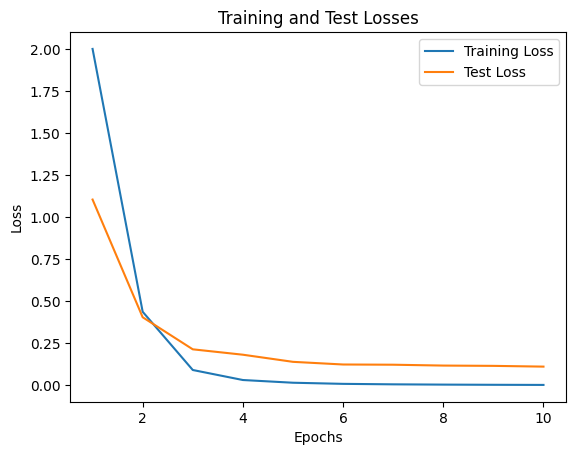

In [11]:
# Plotting the training and validation losses
plt.plot(range(1, EPOCH + 1), train_losses, label='Training Loss')
plt.plot(range(1, EPOCH + 1), test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Test Losses')
plt.legend()
plt.show()


In [12]:
acc_test = [x.cpu() for x in acc_test]
acc_train = [x.cpu() for x in acc_train]

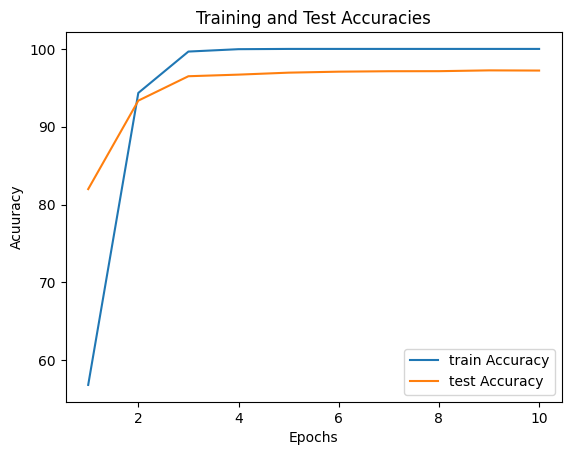

In [ ]:
plt.plot(range(1, EPOCH + 1), torch.stack(acc_train).cpu(), label='train Accuracy')
plt.plot(range(1, EPOCH + 1), torch.stack(acc_test).cpu(), label='test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acuuracy')
plt.title('Training and Test Accuracies')
plt.legend()
plt.show()